<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_regularization_batchTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [40]:
# import dataset (comes with seaborn)
import seaborn as sns

iris = sns.load_dataset('iris')


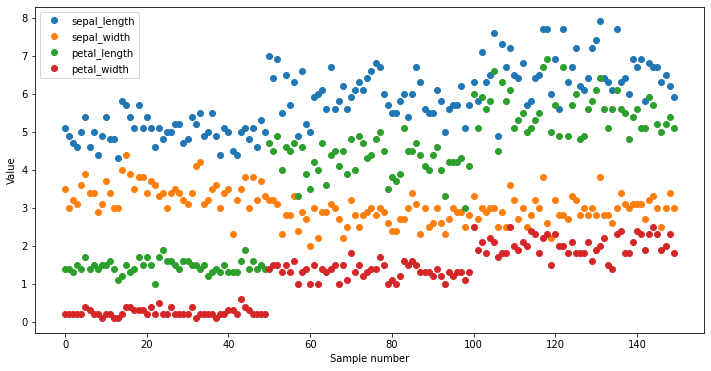

In [41]:
# plot the data
iris.plot(marker='o', linestyle='none', figsize=(12, 6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [42]:

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2


## Break the data into batches

In [43]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# then convert them into pyTorch Datasets (note: already converted to tensor)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally trainslate into dataloader objects
batchsize = 54
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [44]:
# check sizes of data batches
for X, y in train_loader:
    print(X.shape, y.shape)

torch.Size([54, 4]) torch.Size([54])
torch.Size([54, 4]) torch.Size([54])


In [45]:
def createANewModel():
    ANNiris = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3),
    )

    lossfun = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.005)

    return ANNiris, lossfun, optimizer

In [46]:
# explore the model in more detail
tmpModel = createANewModel()[0]
print(tmpModel)

for i in tmpModel.named_parameters(): 
    print(i[0], i[1].shape, i[1].numel())

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [47]:
# train the model

# training parameters
numepochs = 500

def trainTheModel():

    # initialize accuracies as empties (not storing losses here)
    trainAcc = []
    testAcc = []
    losses = []

    # ANNQC.train()
    # switch training mode on (is this the right place for code ??): Nooooooooo

    # count the total number of weights in the model
    # nweights = 0
    # for pname, weight in ANNiris.named_parameters():
    #     if 'bias' not in pname:
    #         nweights = nweights + weight.numel()

    # loop over epochs

    for epochi in range(numepochs):
        

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
            batchLoss.append(loss.item())

        # end of batch loop ...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # test accuracy
        ANNiris.eval() # switch training off
        X, y = next(iter(test_loader)) # extract X, y from test dataloader
        predlabels = torch.argmax(ANNiris(X), axis=1)
        testAcc.append(100 * torch.mean((predlabels == y).float()).item())

        # no worries, reset here :)
        ANNiris.train()


    # function output
    return trainAcc, testAcc, losses

In [48]:
# create a model
ANNiris, lossfun, optimizer = createANewModel()

# train the model
trainAcc, testAcc, losses = trainTheModel()



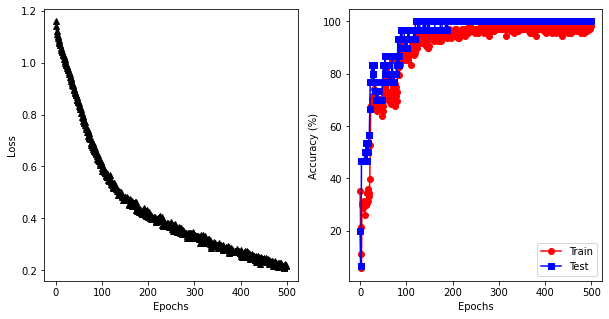

In [49]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(losses, 'k^-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(trainAcc, 'ro-')
ax[1].plot(testAcc, 'bs-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train', 'Test'])

plt.show()